# \[STBDA\] 09wk(2): 확률적 경사하강법

김보람  
2023-07-06

> 해당 강의노트는 전북대학교 최규빈교수님
> [STBDA2022](https://guebin.github.io/STBDA2022/) 자료임

## import

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.experimental.numpy as tnp

In [2]:
tf.config.experimental.list_physical_devices()

In [3]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+ s + ';}')

## 중간고사 관련 잡담

### 중간고사 3번문제

`-` 특이한모형: 오버핏이 일어날 수 없는 모형이다.

-   유의미한 coef: 상수항(bias), $\cos(t)$의 계수, $\cos(2t)$의 계수,
    $\cos(5t)$의 계수.

-   유의미하지 않은 coef: $\cos(3t)$의 계수, $\cos(4t)$의 계수

-   유의미하지 않은 계수는 $n%$이 커질수록 0으로 추정된다 = $\cos(3t)$와
    $\cos(5t)$는 사용자가 임의로 제외하지 않아도 결국 모형에서 알아서
    제거된다 = overfit이 일어나지 않는다. 모형이 알아서 유의미한 변수만
    뽑아서 fit하는 느낌

`-` 3번문제는 overfit이 일어나지 않는다. 이러한 신기한 일이 일어나는
이유는 모든 설명변수가 직교하기 때문임.

-   이런 모형의 장점: overfit이 일어날 위험이 없으므로 train/test로
    나누어 학습할 이유가 없다. (샘플만 버리는 꼴, test에 빼 둔
    observation까지 모아서 학습해 $\beta$를 좀 더 정확히 추론하는게
    차라리 더 이득)

-   이러한 모형에서 할일: 추정된 계수들이 0인지 아닌지만 test하면 된다.
    (이것을 유의성검정이라고 한다)

<span style="color:blue"> 변수가 많아도 오버피팅이 일어나지 않는 경우가
있다. orthogonal한것이 있으면!

`-` 직교기저의 예시

-   빨강과 파랑을 255,255만큼 섞으면 보라색이 된다.

-   빨강과 파랑과 노랑을 각각 255,255,255만큼 섞으면 검은색이 된다.

-   임의의 어떠한 색도 빨강,파랑,노랑의 조합으로 표현가능하다. 즉 \$=
    \*\_1 + \*\_2

-   \*\_3\$ 이다.

-   (빨,파,노)는 색을 표현하는 basis이다. (적절한
    $\beta_1,\beta_2,\beta_3$을 구하기만 하면 임의의 색도 표현가능)

-   (빨,보,노)역시 색을 표현하는 basis라 볼 수 있다. (파란색이 필요할때
    보라색-빨간색을 하면되니까)

-   (빨,보,검)역시 색을 표현하는 basis라 볼 수 있다. (파란색이 필요하면
    보라색-빨간색을 하면되고, 노란색이 필요하면 검정색-보라색을 하면
    되니까)

-   (빨,파,노)는 직교기저이다.

`-` 3번에서 알아둘 것: (1) 직교기저의 개념 (추후 재설명) (2) 임의의 색을
표현하려면 3개의 basis가 필요함

### 중간고사 1-(3)번 문제

`-` 그림을 그려보자.

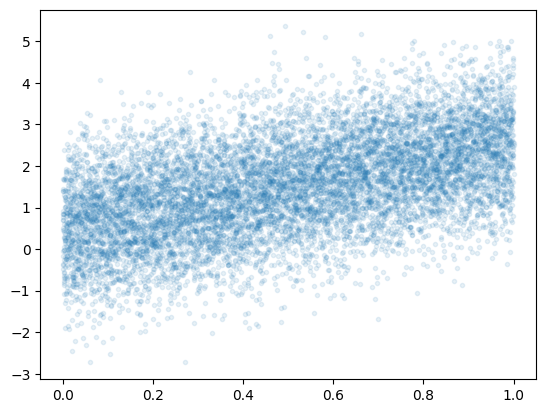

In [5]:
_x= tf.constant(np.arange(1,10001)/10000)
_y= tnp.random.randn(10000) + (0.5 + 2*_x)
plt.plot(_x,_y,'.',alpha=0.1)

`-` 저것 꼭 10000개 다 모아서 loss계산해야할까?

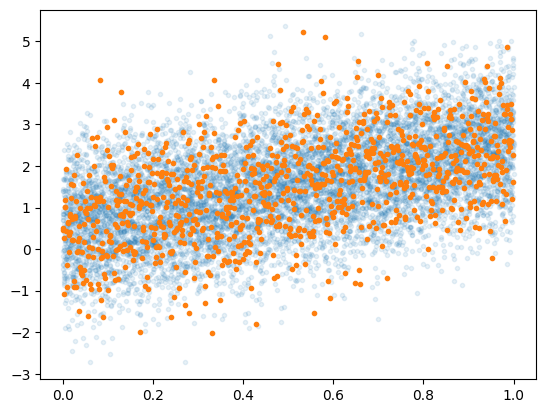

In [6]:
plt.plot(_x,_y,'.',alpha=0.1)
plt.plot(_x[::10],_y[::10],'.')

`-` 대충 이정도만 모아서 해도 비슷하지 않을까? $\to$ 해보자!

## 경사하강법과 확률적경사하강법

### ver1: 모든 샘플을 사용하여 slope계산

`-` 단순회귀분석에서 샘플 10개 관측: $(x_1,y_1),\dots,(x_{10},y_{10})$.

(epoch1)
$loss=\sum_{i=1}^{10}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$

(epoch2)
$loss=\sum_{i=1}^{10}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$

…

### ver2: 하나의 샘플만 사용하여 slope계산

(epoch1) -
$loss=(y_1-\beta_0-\beta_1x_1)^2 \quad \to \quad slope \quad \to \quad update$ -
$loss=(y_2-\beta_0-\beta_1x_2)^2 \quad \to \quad slope \quad \to \quad update$ -
… -
$loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \quad \to \quad slope \quad \to \quad update$

(epoch2) -
$loss=(y_1-\beta_0-\beta_1x_1)^2 \quad \to \quad slope \quad \to \quad update$ -
$loss=(y_2-\beta_0-\beta_1x_2)^2 \quad \to \quad slope \quad \to \quad update$ -
… -
$loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \quad \to \quad slope \quad \to \quad update$

…

### ver3: $m(\leq n)$개의 샘플만 사용하여 slope계산

$m=3$이라고 하자.

(epoch1) -
$loss=\sum_{i=1}^{3}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$ -
$loss=\sum_{i=4}^{6}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$ -
$loss=\sum_{i=7}^{9}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$ -
$loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \quad \to \quad slope \quad \to \quad update$

(epoch2) -
$loss=\sum_{i=1}^{3}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$ -
$loss=\sum_{i=4}^{6}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$ -
$loss=\sum_{i=7}^{9}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$ -
$loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \quad \to \quad slope \quad \to \quad update$

…

### 용어의 정리

#### 옛날 (좀 더 엄밀)

`-` ver1: gradient descent, batch gradient descent

`-` ver2: stochastic gradient descent

:확률적 경사하강법

`-` ver3: mini-batch gradient descent, mini-batch stochastic gradient
descent

#### 요즘

`-` ver1: gradient descent

`-` ver2: stochastic gradient descent with batch size = 1

`-` ver3: stochastic gradient descent -
https://www.deeplearningbook.org/contents/optimization.html, 알고리즘
8-1 참고.

note: 이렇게 많이 쓰는 이유? ver1,2는 사실상 없는 방법이므로

### ver1,2,3 이외에 좀 더 지저분한 것들이 있다.

`-` ver2,3에서 샘플을 셔플할 수도 있다.

`-` ver3에서 일부 샘플이 학습에 참여 안하는 버전도 있다.

`-` 개인적 생각: 크게3개정도만 알면 괜찮고 나머지는 그렇게 유의미하지
않아보인다.

### Discussion

`-` 핵심개념

-   **메모리사용량: ver1 \> ver3 \> ver2**

-   계산속도: ver1 \> ver3 \> ver2

-   local-min에 갇힘: ver1 \> ver3 \> ver2

`-` 본질: GPU 메모리가 한정되어 있어서 ver1을 쓰지는 못한다. GPU
메모리를 가장 적게쓰는것은 ver2인데 이것은 너무 불안정하다.

`-` 틀리진 않지만 어색한 블로그 정리 내용들

-   경사하강법은 종종 국소최소점에 갇히는 문제가 있다. 이를 해결하기
    위해서 등장한 방법이 확률적 경사하강법이다. –\> 영 틀린말은 아니지만
    그걸 의도하고 만든건 아님

-   경사하강법은 계산시간이 오래걸린다. 계산을 빠르게 하기 위해서 등장한
    방법이 확률적 경사하강법이다. –\> 1회 업데이트는 빠르게 계산함.
    하지만 그것이 최적의 $\beta$를 빠르게 얻을 수 있다는 의미는 아님

## fashion_mnist 모듈

### tf.keras.datasets.fashion_mnist.load_data()

`-` tf.keras.datasets.fashion_mnist.load_data 의 리턴값 조사

In [7]:
type(tf.keras.datasets.fashion_mnist)

In [8]:
tf.keras.datasets.fashion_mnist.load_data??

### 데이터생성 및 탐색

`-` tf.keras.datasets.fashion_mnist.load_data()를 이용한 데이터 생성

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

`-` 차원확인

In [10]:
x_train.shape, y_train.shape, x_test.shape,y_test.shape

-   60000은 obs숫자인듯

-   (28,28)은 28픽셀,28픽셀을 의미하는듯

-   train/test는 6:1로 나눈것 같음

`-` 첫번째 obs

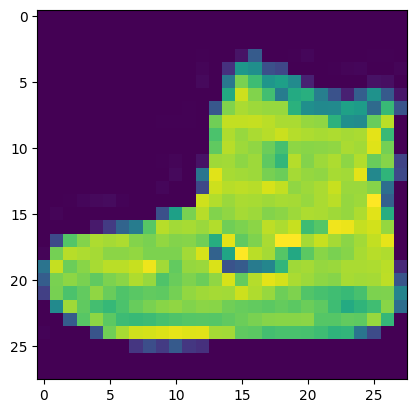

In [11]:
plt.imshow(x_train[0])

In [12]:
y_train[0]

-   첫번쨰 obs에 대응하는 라벨

`-` 첫번째 obs와 동일한 라벨을 가지는 그림을 찾아보자.

In [13]:
np.where(y_train==9)

In [14]:
y_train[11]

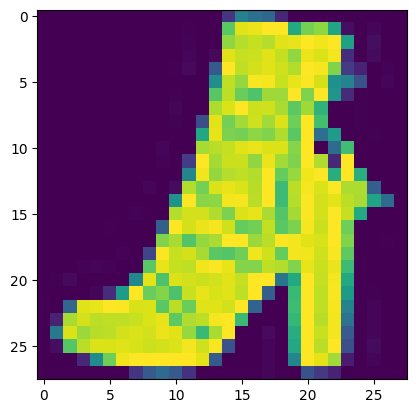

In [15]:
plt.imshow(x_train[11])

### 데이터구조

`-` ${\bf X}$: (n,28,28)

`-` ${\bf y}$: (n,) , $y=0,1,2,3,\dots,9$

## 예제1

### 데이터 정리

`-` y=0,1에 대응하는 이미지만 정리하자. (우리가 배운건 로지스틱이니까)

In [17]:
y= y_train[(y_train==0) | (y_train==1)].reshape(-1,1)
X= x_train[(y_train==0) | (y_train==1)].reshape(-1,784)
yy= y_test[(y_test==0) | (y_test==1)].reshape(-1,1)
XX= x_test[(y_test==0) | (y_test==1)].reshape(-1,784)

<span style="color:blue"> y_rain==0 \| y_rain==1 할때 가로 () 통해서
묶어줘야 컴퓨터가 잘 계산함. 안그러면 오류남.

In [19]:
28*28

In [18]:
X.shape, y.shape, XX.shape, yy.shape

### 풀이1: 은닉층을 포함한 신경망 // epochs=100

In [16]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"

    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"

    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node30"
    "x2" -> "node30"
    ".." -> "node30"
    "x784" -> "node30"


    label = "Layer 1: relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node30" -> "y"
    label = "Layer 2: sigmoid"
}
''')

In [26]:
tf.random.set_seed(43052)
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='sgd',loss=tf.losses.binary_crossentropy)
net.fit(X,y,epochs=100,batch_size=12000)

Epoch 1/100
1/1 [==============================] - 0s 160ms/step - loss: 92.5370
Epoch 2/100
1/1 [==============================] - 0s 10ms/step - loss: 17046.6074
Epoch 3/100
1/1 [==============================] - 0s 10ms/step - loss: 1.0171
Epoch 4/100
1/1 [==============================] - 0s 10ms/step - loss: 0.7000
Epoch 5/100
1/1 [==============================] - 0s 11ms/step - loss: 0.6993
Epoch 6/100
1/1 [==============================] - 0s 10ms/step - loss: 0.6987
Epoch 7/100
1/1 [==============================] - 0s 11ms/step - loss: 0.6982
Epoch 8/100
1/1 [==============================] - 0s 11ms/step - loss: 0.6977
Epoch 9/100
1/1 [==============================] - 0s 10ms/step - loss: 0.6973
Epoch 10/100
1/1 [==============================] - 0s 10ms/step - loss: 0.6970
Epoch 11/100
1/1 [==============================] - 0s 10ms/step - loss: 0.6966
Epoch 12/100
1/1 [==============================] - 0s 11ms/step - loss: 0.6963
Epoch 13/100
1/1 [=========================

In [27]:
np.mean((net(X)>0.5) == y)

In [28]:
np.mean((net(XX)>0.5) == yy)

<span style="color:blue"> 옵티마이저 sgd로 하니까 local-min에 갇힘

### 풀이2: 옵티마이저 개선

In [23]:
tf.random.set_seed(43052)
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='adam',loss=tf.losses.binary_crossentropy)
net.fit(X,y,epochs=100,batch_size=12000)

Epoch 1/100
1/1 [==============================] - 0s 306ms/step - loss: 65.5856
Epoch 2/100
1/1 [==============================] - 0s 11ms/step - loss: 19.6951
Epoch 3/100
1/1 [==============================] - 0s 11ms/step - loss: 20.4201
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 10.9633
Epoch 5/100
1/1 [==============================] - 0s 10ms/step - loss: 6.0247
Epoch 6/100
1/1 [==============================] - 0s 11ms/step - loss: 4.8173
Epoch 7/100
1/1 [==============================] - 0s 11ms/step - loss: 4.5056
Epoch 8/100
1/1 [==============================] - 0s 11ms/step - loss: 4.5642
Epoch 9/100
1/1 [==============================] - 0s 11ms/step - loss: 4.8446
Epoch 10/100
1/1 [==============================] - 0s 10ms/step - loss: 5.1005
Epoch 11/100
1/1 [==============================] - 0s 11ms/step - loss: 5.1322
Epoch 12/100
1/1 [==============================] - 0s 11ms/step - loss: 4.8958
Epoch 13/100
1/1 [==========================

In [24]:
np.mean((net(X)>0.5) == y)

In [25]:
np.mean((net(XX)>0.5) == yy)

### 풀이3: 컴파일시 metrics=\[‘accuracy’\] 추가

In [29]:
tf.random.set_seed(43052)
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='adam',loss=tf.losses.binary_crossentropy,metrics=['accuracy'])
net.fit(X,y,epochs=100,batch_size=12000)

Epoch 1/100
1/1 [==============================] - 0s 242ms/step - loss: 28.7517 - accuracy: 0.5519
Epoch 2/100
1/1 [==============================] - 0s 11ms/step - loss: 25.1717 - accuracy: 0.6363
Epoch 3/100
1/1 [==============================] - 0s 11ms/step - loss: 21.2647 - accuracy: 0.6923
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 9.8526 - accuracy: 0.8635
Epoch 5/100
1/1 [==============================] - 0s 11ms/step - loss: 5.4689 - accuracy: 0.9360
Epoch 6/100
1/1 [==============================] - 0s 11ms/step - loss: 4.2996 - accuracy: 0.9312
Epoch 7/100
1/1 [==============================] - 0s 12ms/step - loss: 5.0362 - accuracy: 0.9087
Epoch 8/100
1/1 [==============================] - 0s 12ms/step - loss: 6.4399 - accuracy: 0.8825
Epoch 9/100
1/1 [==============================] - 0s 11ms/step - loss: 6.9378 - accuracy: 0.8757
Epoch 10/100
1/1 [==============================] - 0s 14ms/step - loss: 6.0575 - accuracy: 0.8892
Epoch 11/100
1/

In [30]:
net.evaluate(X,y)

375/375 [==============================] - 0s 402us/step - loss: 0.4845 - accuracy: 0.9849

In [31]:
net.evaluate(XX,yy)

63/63 [==============================] - 0s 420us/step - loss: 0.6619 - accuracy: 0.9755

### 풀이4: 확률적경사하강법 이용 // epochs=10

In [32]:
tf.random.set_seed(43052)
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='adam',loss=tf.losses.binary_crossentropy,metrics=['accuracy'])
net.fit(X,y,epochs=10,batch_size=120)

Epoch 1/10
100/100 [==============================] - 0s 807us/step - loss: 1.8125 - accuracy: 0.9566
Epoch 2/10
100/100 [==============================] - 0s 633us/step - loss: 0.5900 - accuracy: 0.9791
Epoch 3/10
100/100 [==============================] - 0s 634us/step - loss: 0.4965 - accuracy: 0.9822
Epoch 4/10
100/100 [==============================] - 0s 605us/step - loss: 0.3176 - accuracy: 0.9849
Epoch 5/10
100/100 [==============================] - 0s 629us/step - loss: 0.1967 - accuracy: 0.9896
Epoch 6/10
100/100 [==============================] - 0s 631us/step - loss: 0.2400 - accuracy: 0.9872
Epoch 7/10
100/100 [==============================] - 0s 606us/step - loss: 0.1644 - accuracy: 0.9902
Epoch 8/10
100/100 [==============================] - 0s 602us/step - loss: 0.1564 - accuracy: 0.9903
Epoch 9/10
100/100 [==============================] - 0s 615us/step - loss: 0.1128 - accuracy: 0.9931
Epoch 10/10
100/100 [==============================] - 0s 627us/step - loss: 0.109

In [33]:
net.evaluate(X,y)

375/375 [==============================] - 0s 379us/step - loss: 0.0361 - accuracy: 0.9956

In [34]:
net.evaluate(XX,yy)

63/63 [==============================] - 0s 442us/step - loss: 0.2614 - accuracy: 0.9870